In [4]:
import torch
import torch.utils.data as data
from matplotlib import pyplot as plt
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torch import nn
import os
import cv2
import numpy as np
from torch.nn import functional as F
from helpers.dataset import IconsDataset, basic_img_transform as img_transform
from helpers.visualization import visualize_images
from helpers.vae import Autoencoder, loss_function

In [5]:
root_dir = 'icons/png32/images/'
BATCH_SIZE = 64
num_epochs = 150

In [6]:
dataset = IconsDataset(root_dir, transform=img_transform)

In [7]:
loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [8]:
model = Autoencoder().cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)

RuntimeError: CUDA error: out of memory

In [11]:
from tqdm import tqdm
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for data in loader:
        img = data
        img = Variable(img).cuda()
        img = img.view(-1, 3, 32, 32)
        # ===================forward=====================
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        total_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append(total_loss)
    torch.save(model.state_dict(), 'VAE')
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, total_loss))

  1%|          | 1/150 [00:01<03:02,  1.23s/it]

epoch [1/150], loss:10914477.1016


  1%|▏         | 2/150 [00:02<02:58,  1.21s/it]

epoch [2/150], loss:10235473.7695


  2%|▏         | 3/150 [00:03<02:56,  1.20s/it]

epoch [3/150], loss:9795182.0059


  3%|▎         | 4/150 [00:04<02:54,  1.19s/it]

epoch [4/150], loss:9484597.9297


  3%|▎         | 5/150 [00:05<02:51,  1.18s/it]

epoch [5/150], loss:9213061.4980


  4%|▍         | 6/150 [00:07<02:49,  1.18s/it]

epoch [6/150], loss:8962503.5332


  5%|▍         | 7/150 [00:08<02:47,  1.17s/it]

epoch [7/150], loss:8764326.6133


  5%|▌         | 8/150 [00:09<02:45,  1.17s/it]

epoch [8/150], loss:8604001.9375


  6%|▌         | 9/150 [00:10<02:57,  1.26s/it]

epoch [9/150], loss:8463869.7891


  7%|▋         | 10/150 [00:12<03:04,  1.32s/it]

epoch [10/150], loss:8349374.9453


  7%|▋         | 11/150 [00:13<03:03,  1.32s/it]

epoch [11/150], loss:8247571.0215


  8%|▊         | 12/150 [00:14<03:01,  1.31s/it]

epoch [12/150], loss:8150165.4219


  9%|▊         | 13/150 [00:16<02:57,  1.30s/it]

epoch [13/150], loss:8061774.9355


  9%|▉         | 14/150 [00:17<02:58,  1.31s/it]

epoch [14/150], loss:7984106.5781


 10%|█         | 15/150 [00:18<02:54,  1.29s/it]

epoch [15/150], loss:7915479.3086


 11%|█         | 16/150 [00:20<02:56,  1.32s/it]

epoch [16/150], loss:7848065.4766


 11%|█▏        | 17/150 [00:21<02:55,  1.32s/it]

epoch [17/150], loss:7786456.3125


 12%|█▏        | 18/150 [00:22<02:56,  1.34s/it]

epoch [18/150], loss:7726231.6504


 13%|█▎        | 19/150 [00:24<02:58,  1.36s/it]

epoch [19/150], loss:7670985.9727


 13%|█▎        | 20/150 [00:25<03:05,  1.43s/it]

epoch [20/150], loss:7616794.5508


 14%|█▍        | 21/150 [00:27<03:07,  1.45s/it]

epoch [21/150], loss:7566462.3730


 15%|█▍        | 22/150 [00:28<02:57,  1.38s/it]

epoch [22/150], loss:7526263.7344


 15%|█▌        | 23/150 [00:29<02:50,  1.34s/it]

epoch [23/150], loss:7484439.7695


 16%|█▌        | 24/150 [00:31<02:44,  1.30s/it]

epoch [24/150], loss:7442853.1230


 17%|█▋        | 25/150 [00:32<02:39,  1.28s/it]

epoch [25/150], loss:7399086.8555


 17%|█▋        | 26/150 [00:33<02:35,  1.25s/it]

epoch [26/150], loss:7372180.3750


 18%|█▊        | 27/150 [00:34<02:36,  1.27s/it]

epoch [27/150], loss:7335925.2520


 19%|█▊        | 28/150 [00:36<02:33,  1.26s/it]

epoch [28/150], loss:7297623.6738


 19%|█▉        | 29/150 [00:37<02:29,  1.24s/it]

epoch [29/150], loss:7270339.3535


 20%|██        | 30/150 [00:38<02:27,  1.23s/it]

epoch [30/150], loss:7239431.7461


 21%|██        | 31/150 [00:39<02:25,  1.22s/it]

epoch [31/150], loss:7211486.1152


 21%|██▏       | 32/150 [00:40<02:23,  1.22s/it]

epoch [32/150], loss:7177425.2930


 22%|██▏       | 33/150 [00:42<02:23,  1.22s/it]

epoch [33/150], loss:7155041.1660


 23%|██▎       | 34/150 [00:43<02:21,  1.22s/it]

epoch [34/150], loss:7130930.0703


 23%|██▎       | 35/150 [00:44<02:20,  1.22s/it]

epoch [35/150], loss:7103108.4375


 24%|██▍       | 36/150 [00:45<02:18,  1.21s/it]

epoch [36/150], loss:7087582.5938


 25%|██▍       | 37/150 [00:46<02:16,  1.21s/it]

epoch [37/150], loss:7068708.2773


 25%|██▌       | 38/150 [00:48<02:14,  1.20s/it]

epoch [38/150], loss:7052175.1055


 26%|██▌       | 39/150 [00:49<02:13,  1.20s/it]

epoch [39/150], loss:7027375.4941


 27%|██▋       | 40/150 [00:50<02:13,  1.21s/it]

epoch [40/150], loss:7016300.8457


 27%|██▋       | 41/150 [00:51<02:13,  1.22s/it]

epoch [41/150], loss:6993583.2988


 28%|██▊       | 42/150 [00:52<02:11,  1.22s/it]

epoch [42/150], loss:6982415.4863


 29%|██▊       | 43/150 [00:54<02:09,  1.21s/it]

epoch [43/150], loss:6964580.5137


 29%|██▉       | 44/150 [00:55<02:11,  1.24s/it]

epoch [44/150], loss:6953994.8145


 30%|███       | 45/150 [00:56<02:10,  1.24s/it]

epoch [45/150], loss:6941514.7031


 31%|███       | 46/150 [00:57<02:07,  1.23s/it]

epoch [46/150], loss:6923189.9688


 31%|███▏      | 47/150 [00:59<02:05,  1.22s/it]

epoch [47/150], loss:6918441.2734


 32%|███▏      | 48/150 [01:00<02:03,  1.21s/it]

epoch [48/150], loss:6902337.9043


 33%|███▎      | 49/150 [01:01<02:02,  1.21s/it]

epoch [49/150], loss:6887852.0645


 33%|███▎      | 50/150 [01:02<02:00,  1.21s/it]

epoch [50/150], loss:6876733.8867


 34%|███▍      | 51/150 [01:03<01:58,  1.20s/it]

epoch [51/150], loss:6871411.1309


 35%|███▍      | 52/150 [01:05<02:00,  1.23s/it]

epoch [52/150], loss:6854258.9180


 35%|███▌      | 53/150 [01:06<01:58,  1.22s/it]

epoch [53/150], loss:6851366.8574


 36%|███▌      | 54/150 [01:07<01:57,  1.22s/it]

epoch [54/150], loss:6836229.1602


 37%|███▋      | 55/150 [01:08<01:55,  1.21s/it]

epoch [55/150], loss:6826235.1543


 37%|███▋      | 56/150 [01:10<01:53,  1.21s/it]

epoch [56/150], loss:6821348.7168


 38%|███▊      | 57/150 [01:11<01:53,  1.22s/it]

epoch [57/150], loss:6810896.4844


 39%|███▊      | 58/150 [01:12<01:52,  1.22s/it]

epoch [58/150], loss:6799198.0664


 39%|███▉      | 59/150 [01:13<01:50,  1.21s/it]

epoch [59/150], loss:6791474.6543


 40%|████      | 60/150 [01:15<01:55,  1.28s/it]

epoch [60/150], loss:6784281.1406


 41%|████      | 61/150 [01:16<01:53,  1.27s/it]

epoch [61/150], loss:6777688.5508


 41%|████▏     | 62/150 [01:17<01:49,  1.24s/it]

epoch [62/150], loss:6764965.1562


 42%|████▏     | 63/150 [01:18<01:45,  1.22s/it]

epoch [63/150], loss:6767023.6758


 43%|████▎     | 64/150 [01:19<01:43,  1.21s/it]

epoch [64/150], loss:6758350.7461


 43%|████▎     | 65/150 [01:21<01:44,  1.23s/it]

epoch [65/150], loss:6751493.1426


 44%|████▍     | 66/150 [01:22<01:45,  1.25s/it]

epoch [66/150], loss:6742833.9746


 45%|████▍     | 67/150 [01:23<01:43,  1.25s/it]

epoch [67/150], loss:6735713.6797


 45%|████▌     | 68/150 [01:24<01:42,  1.25s/it]

epoch [68/150], loss:6728528.3594


 46%|████▌     | 69/150 [01:26<01:39,  1.23s/it]

epoch [69/150], loss:6719419.2051


 47%|████▋     | 70/150 [01:27<01:37,  1.21s/it]

epoch [70/150], loss:6718479.4219


 47%|████▋     | 71/150 [01:28<01:35,  1.21s/it]

epoch [71/150], loss:6716651.2031


 48%|████▊     | 72/150 [01:29<01:33,  1.20s/it]

epoch [72/150], loss:6705453.5078


 49%|████▊     | 73/150 [01:30<01:32,  1.20s/it]

epoch [73/150], loss:6700902.6348


 49%|████▉     | 74/150 [01:32<01:31,  1.20s/it]

epoch [74/150], loss:6693605.4219


 50%|█████     | 75/150 [01:33<01:43,  1.38s/it]

epoch [75/150], loss:6694185.8594


 51%|█████     | 76/150 [01:35<01:43,  1.41s/it]

epoch [76/150], loss:6691841.8438


 51%|█████▏    | 77/150 [01:37<01:59,  1.64s/it]

epoch [77/150], loss:6684714.9043


 52%|█████▏    | 78/150 [01:38<01:53,  1.57s/it]

epoch [78/150], loss:6679973.0137


 53%|█████▎    | 79/150 [01:40<01:43,  1.46s/it]

epoch [79/150], loss:6678182.4766


 53%|█████▎    | 80/150 [01:41<01:35,  1.37s/it]

epoch [80/150], loss:6670171.3457


 54%|█████▍    | 81/150 [01:42<01:30,  1.32s/it]

epoch [81/150], loss:6663465.6172


 55%|█████▍    | 82/150 [01:43<01:26,  1.28s/it]

epoch [82/150], loss:6662245.3945


 55%|█████▌    | 83/150 [01:44<01:23,  1.24s/it]

epoch [83/150], loss:6658537.4023


 56%|█████▌    | 84/150 [01:46<01:20,  1.23s/it]

epoch [84/150], loss:6656063.6133


 57%|█████▋    | 85/150 [01:47<01:23,  1.29s/it]

epoch [85/150], loss:6650355.0664


 57%|█████▋    | 86/150 [01:48<01:20,  1.25s/it]

epoch [86/150], loss:6640459.3613


 58%|█████▊    | 87/150 [01:49<01:20,  1.28s/it]

epoch [87/150], loss:6641119.8652


 59%|█████▊    | 88/150 [01:51<01:18,  1.27s/it]

epoch [88/150], loss:6639642.7578


 59%|█████▉    | 89/150 [01:52<01:20,  1.31s/it]

epoch [89/150], loss:6635456.8672


 60%|██████    | 90/150 [01:54<01:24,  1.40s/it]

epoch [90/150], loss:6632799.2129


 61%|██████    | 91/150 [01:55<01:19,  1.35s/it]

epoch [91/150], loss:6624630.2266


 61%|██████▏   | 92/150 [01:57<01:24,  1.45s/it]

epoch [92/150], loss:6617895.2734


 62%|██████▏   | 93/150 [01:58<01:18,  1.38s/it]

epoch [93/150], loss:6618412.2656


 63%|██████▎   | 94/150 [01:59<01:20,  1.43s/it]

epoch [94/150], loss:6618610.1152


 63%|██████▎   | 95/150 [02:01<01:18,  1.42s/it]

epoch [95/150], loss:6613153.6680


 64%|██████▍   | 96/150 [02:02<01:17,  1.44s/it]

epoch [96/150], loss:6611828.3672


 65%|██████▍   | 97/150 [02:04<01:20,  1.53s/it]

epoch [97/150], loss:6602911.1328


 65%|██████▌   | 98/150 [02:06<01:25,  1.65s/it]

epoch [98/150], loss:6602597.4160


 66%|██████▌   | 99/150 [02:07<01:20,  1.57s/it]

epoch [99/150], loss:6604533.2207


 67%|██████▋   | 100/150 [02:09<01:16,  1.53s/it]

epoch [100/150], loss:6598965.3594


 67%|██████▋   | 101/150 [02:10<01:14,  1.52s/it]

epoch [101/150], loss:6595176.8672


 68%|██████▊   | 102/150 [02:11<01:08,  1.42s/it]

epoch [102/150], loss:6587614.5977


 69%|██████▊   | 103/150 [02:13<01:05,  1.39s/it]

epoch [103/150], loss:6589307.1641


 69%|██████▉   | 104/150 [02:14<01:05,  1.43s/it]

epoch [104/150], loss:6584169.6641


 70%|███████   | 105/150 [02:16<01:02,  1.38s/it]

epoch [105/150], loss:6591333.5527


 71%|███████   | 106/150 [02:17<01:00,  1.37s/it]

epoch [106/150], loss:6582959.2734


 71%|███████▏  | 107/150 [02:18<00:56,  1.32s/it]

epoch [107/150], loss:6576428.7637


 72%|███████▏  | 108/150 [02:19<00:53,  1.28s/it]

epoch [108/150], loss:6578545.1426


 73%|███████▎  | 109/150 [02:20<00:50,  1.24s/it]

epoch [109/150], loss:6573491.7852


 73%|███████▎  | 110/150 [02:22<00:50,  1.26s/it]

epoch [110/150], loss:6572005.8945


 74%|███████▍  | 111/150 [02:23<00:50,  1.30s/it]

epoch [111/150], loss:6568332.3574


 75%|███████▍  | 112/150 [02:25<00:50,  1.33s/it]

epoch [112/150], loss:6569001.0801


 75%|███████▌  | 113/150 [02:26<00:47,  1.28s/it]

epoch [113/150], loss:6564943.9258


 76%|███████▌  | 114/150 [02:27<00:46,  1.30s/it]

epoch [114/150], loss:6561479.3281


 77%|███████▋  | 115/150 [02:29<00:47,  1.34s/it]

epoch [115/150], loss:6560728.0703


 77%|███████▋  | 116/150 [02:30<00:44,  1.31s/it]

epoch [116/150], loss:6557372.5586


 78%|███████▊  | 117/150 [02:31<00:42,  1.29s/it]

epoch [117/150], loss:6555266.5957


 79%|███████▊  | 118/150 [02:32<00:40,  1.27s/it]

epoch [118/150], loss:6550687.9258


 79%|███████▉  | 119/150 [02:33<00:38,  1.25s/it]

epoch [119/150], loss:6550931.9727


 80%|████████  | 120/150 [02:35<00:37,  1.25s/it]

epoch [120/150], loss:6550094.5938


 81%|████████  | 121/150 [02:36<00:36,  1.26s/it]

epoch [121/150], loss:6549428.2676


 81%|████████▏ | 122/150 [02:37<00:35,  1.26s/it]

epoch [122/150], loss:6543980.1992


 82%|████████▏ | 123/150 [02:38<00:33,  1.25s/it]

epoch [123/150], loss:6546035.9062


 83%|████████▎ | 124/150 [02:40<00:32,  1.23s/it]

epoch [124/150], loss:6537450.1895


 83%|████████▎ | 125/150 [02:41<00:30,  1.22s/it]

epoch [125/150], loss:6537235.6953


 84%|████████▍ | 126/150 [02:42<00:29,  1.22s/it]

epoch [126/150], loss:6539490.9336


 85%|████████▍ | 127/150 [02:43<00:27,  1.21s/it]

epoch [127/150], loss:6534175.8320


 85%|████████▌ | 128/150 [02:44<00:26,  1.21s/it]

epoch [128/150], loss:6536615.0762


 86%|████████▌ | 129/150 [02:46<00:26,  1.27s/it]

epoch [129/150], loss:6529759.6602


 87%|████████▋ | 130/150 [02:48<00:29,  1.47s/it]

epoch [130/150], loss:6535358.5156


 87%|████████▋ | 131/150 [02:50<00:31,  1.67s/it]

epoch [131/150], loss:6528573.5742


 88%|████████▊ | 132/150 [02:52<00:31,  1.75s/it]

epoch [132/150], loss:6524863.4766


 89%|████████▊ | 133/150 [02:53<00:27,  1.62s/it]

epoch [133/150], loss:6523874.0742


 89%|████████▉ | 134/150 [02:54<00:23,  1.50s/it]

epoch [134/150], loss:6521114.1680


 90%|█████████ | 135/150 [02:56<00:21,  1.41s/it]

epoch [135/150], loss:6521476.4062


 91%|█████████ | 136/150 [02:57<00:18,  1.34s/it]

epoch [136/150], loss:6513698.1953


 91%|█████████▏| 137/150 [02:58<00:16,  1.30s/it]

epoch [137/150], loss:6517203.7617


 92%|█████████▏| 138/150 [02:59<00:15,  1.27s/it]

epoch [138/150], loss:6516936.9844


 93%|█████████▎| 139/150 [03:00<00:13,  1.24s/it]

epoch [139/150], loss:6515383.8125


 93%|█████████▎| 140/150 [03:02<00:12,  1.24s/it]

epoch [140/150], loss:6510274.2910


 94%|█████████▍| 141/150 [03:03<00:11,  1.24s/it]

epoch [141/150], loss:6510414.6953


 95%|█████████▍| 142/150 [03:04<00:09,  1.24s/it]

epoch [142/150], loss:6506963.0352


 95%|█████████▌| 143/150 [03:05<00:08,  1.23s/it]

epoch [143/150], loss:6508279.6133


 96%|█████████▌| 144/150 [03:07<00:07,  1.22s/it]

epoch [144/150], loss:6508520.6133


 97%|█████████▋| 145/150 [03:08<00:06,  1.21s/it]

epoch [145/150], loss:6507291.5117


 97%|█████████▋| 146/150 [03:09<00:04,  1.21s/it]

epoch [146/150], loss:6502368.0371


 98%|█████████▊| 147/150 [03:10<00:03,  1.20s/it]

epoch [147/150], loss:6496840.5293


 99%|█████████▊| 148/150 [03:11<00:02,  1.21s/it]

epoch [148/150], loss:6495619.5078


 99%|█████████▉| 149/150 [03:13<00:01,  1.21s/it]

epoch [149/150], loss:6499150.3164


100%|██████████| 150/150 [03:14<00:00,  1.30s/it]

epoch [150/150], loss:6495136.5625


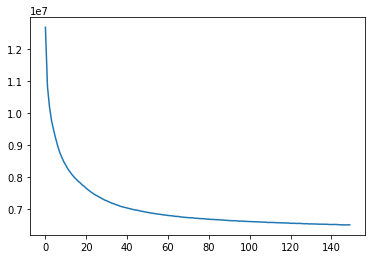

In [20]:
plt.plot(losses)

In [16]:
convert = lambda x:np.transpose(x, (1, 2, 0))

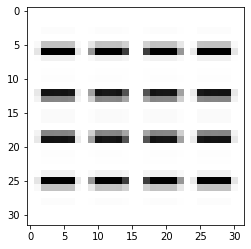

In [22]:
test_batch = next(iter(loader))
plt.imshow(convert(test_batch[1]))

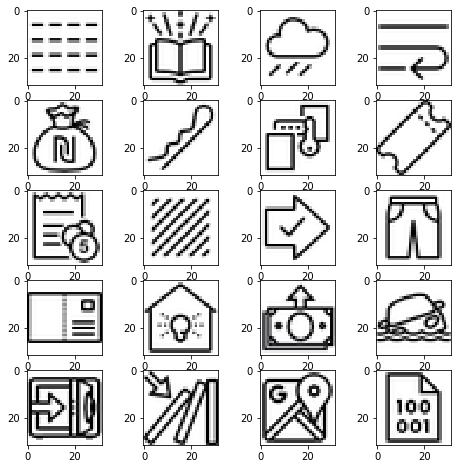

In [23]:
var = Variable(test_batch).cuda()
test_batch = test_batch.view(-1, 3, 32, 32)
res = model(var)
visualize_images(test_batch, function=convert,cmap='gray')

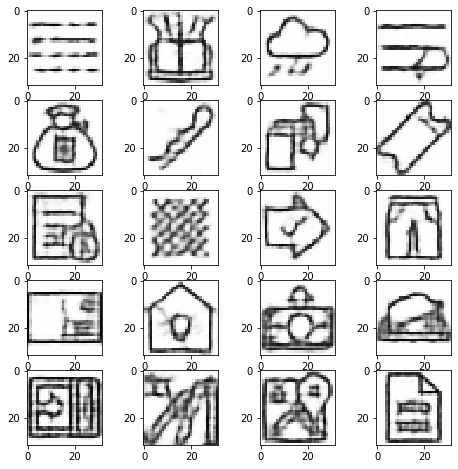

In [24]:
#.cpu().detach().numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(convert(res[0][i].cpu().detach().numpy()))
plt.show()

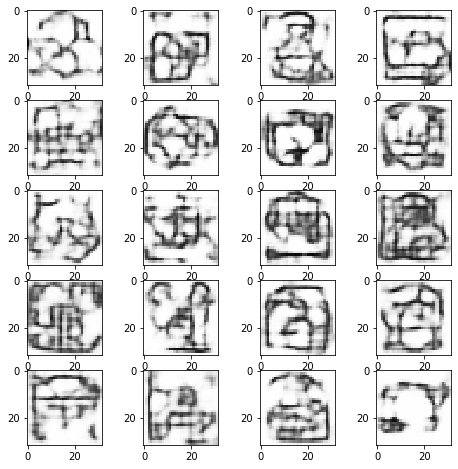

In [25]:
with torch.no_grad():
    sample = torch.randn(64, 300).cuda()
    sample = model.decode(sample).cpu()
    visualize_images(sample, function=convert, cmap='gray')    

In [9]:
!mkdir generated
!mkdir ./generated/VAE

In [11]:
V = Autoencoder().cuda()

In [12]:
test_generator_dict = torch.load('VAE')
V.load_state_dict(test_generator_dict)

<All keys matched successfully>

In [18]:
sample = torch.randn(64, 300).cuda()
sample = V.decode(sample).cpu().detach().numpy()

In [19]:
import os

path = 'generated/VAE/'
i = 0 
for image in sample:
    image = convert(image)
    pth = os.path.join(path, '{}.png'.format(i))
    plt.imsave(pth, image, cmap='gray')
    i += 1